<a href="https://colab.research.google.com/github/Thien-Nhan-28/Essay/blob/main/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Kết nối với Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Essay'


Mounted at /content/gdrive
/content/gdrive/MyDrive/Essay


In [ ]:
pip install tensorflow


### 2. Import thư viện

In [ ]:
import pandas as pd
import glob2
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


### 3. Đọc dữ liệu và gán nhãn

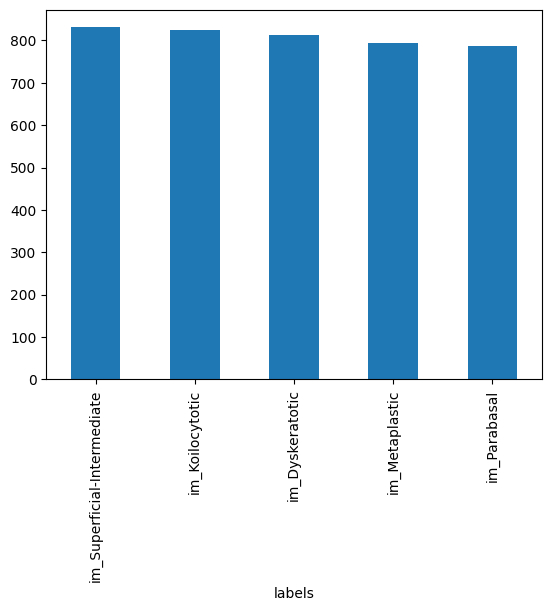

labels
im_Superficial-Intermediate    831
im_Koilocytotic                825
im_Dyskeratotic                813
im_Metaplastic                 793
im_Parabasal                   787
Name: count, dtype: int64


In [ ]:
# Danh sách các lớp
classes = ["im_Dyskeratotic", "im_Koilocytotic", "im_Metaplastic",
           "im_Parabasal", "im_Superficial-Intermediate"]

labels = []
image_links = []
class_path = '/content/gdrive/MyDrive/Essay'

# Load tất cả ảnh và gán nhãn tương ứng
for class_name in classes:
    images = glob2.glob(f'{class_path}/{class_name}/{class_name}/CROPPED/*.bmp')
    labels.extend([class_name] * len(images))
    image_links.extend(images)

# Chuyển dữ liệu vào DataFrame để tiện xử lý
data = pd.DataFrame({'labels': labels, 'image_links': image_links})

# Kiểm tra số lượng ảnh trên mỗi lớp
data['labels'].value_counts().plot.bar()
plt.show()
print(data['labels'].value_counts())


### 4. Chia tập dữ liệu

In [ ]:
# Chia tập test trước (15%)
images_train_val, images_test, y_train_val, y_test = train_test_split(
    image_links, labels, stratify=labels, test_size=0.15, random_state=42
)

print(f'Train + Val: {len(images_train_val)}, Test: {len(images_test)}')
 # Chia tập train và validation từ tập train_val
images_train, images_val, y_train, y_val = train_test_split(
    images_train_val, y_train_val, stratify=y_train_val, test_size=0.176, random_state=42
)

print(f'Train: {len(images_train)}, Val: {len(images_val)}, Test: {len(images_test)}')


Train + Val: 3441, Test: 608
Train: 2835, Val: 606, Test: 608


### 5. Chuẩn hóa hình ảnh

In [ ]:
def load_and_resize_image(img_path, target_size=(299, 299)):
    img = cv2.imread(img_path)  # Đọc ảnh
    if img is None:
        print(f"Error reading image: {img_path}")
        return None

    img_resized = cv2.resize(img, target_size)  # Resize ảnh
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)  # Đổi sang RGB
    img_normalized = img_rgb / 255.0  # Chuẩn hóa hình ảnh
    return img_normalized

# Kiểm tra và đảm bảo rằng tất cả ảnh đều đúng kích thước
processed_images = []  # Danh sách để lưu trữ các hình ảnh đã xử lý

# Thay đổi cách xử lý hình ảnh để chỉ gọi hàm một lần cho mỗi đường dẫn
for img_path in image_links:
    img = load_and_resize_image(img_path)
    if img is not None:
        processed_images.append(img)  # Thêm hình ảnh đã xử lý vào danh sách

# In ra kích thước ảnh đã được xử lý
for img_path, img in zip(image_links, processed_images):
    if img is not None:
        print(f"Processed image shape for {img_path}: {img.shape}")




Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/111_06.bmp: (299, 299, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/112_03.bmp: (299, 299, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/111_04.bmp: (299, 299, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/111_02.bmp: (299, 299, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/113_03.bmp: (299, 299, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/114_11.bmp: (299, 299, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/113_02.bmp: (299, 299, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/114_02.bmp: (299, 299, 3)
Processed image shape fo

In [ ]:
# Khởi tạo ImageDataGenerator cho tập huấn luyện với tăng cường dữ liệu
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Chuẩn hóa cho InceptionV3
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Khởi tạo ImageDataGenerator cho tập kiểm tra (không tăng cường)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Khởi tạo ImageDataGenerator cho tập test (không tăng cường)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# Khởi tạo LabelEncoder
encoder = LabelEncoder()

# Chuyển đổi nhãn thành số cho tập huấn luyện và validation
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

# Chuyển đổi nhãn sang dạng one-hot cho tập huấn luyện và validation
y_train_onehot = to_categorical(y_train_encoded, num_classes=5)
y_val_onehot = to_categorical(y_val_encoded, num_classes=5)

# Chuyển đổi nhãn thành số cho tập test (không cần one-hot)
y_test_encoded = encoder.transform(y_test)  # Đảm bảo bạn đã có biến y_test


In [ ]:
# Tạo generators cho tập huấn luyện
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_links': images_train, 'labels': y_train}),
    x_col='image_links',
    y_col='labels',
    target_size=(299, 299),  # Thay đổi kích thước hình ảnh
    batch_size=32,
    class_mode='categorical'  # Giữ nguyên nhãn ở dạng string
)

# Tạo generators cho tập kiểm tra
val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_links': images_val, 'labels': y_val}),
    x_col='image_links',
    y_col='labels',
    target_size=(299, 299),  # Thay đổi kích thước hình ảnh
    batch_size=32,
    class_mode='categorical'
)

# Tạo generators cho tập test
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_links': images_test, 'labels': y_test}),
    x_col='image_links',
    y_col='labels',
    target_size=(299, 299),  # Thay đổi kích thước hình ảnh
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Giữ nguyên thứ tự để đánh giá
)


Found 2835 validated image filenames belonging to 5 classes.
Found 606 validated image filenames belonging to 5 classes.
Found 608 validated image filenames belonging to 5 classes.


In [ ]:
# Kiểm tra kích thước của một vài ảnh trong tập huấn luyện
for i in range(5):  # Kiểm tra 5 ảnh đầu tiên
    img = load_and_resize_image(images_train[i])
    if img is not None:
        print(f"Image {i} shape: {img.shape}")  # Kỳ vọng (299, 299, 3)

# Lấy một batch từ train_generator và kiểm tra kích thước
batch_images, batch_labels = next(train_generator)
print(f'Batch image shape: {batch_images.shape}')  # Kỳ vọng (32, 299, 299, 3)
print(f'Batch label shape: {batch_labels.shape}')  # Kỳ vọng (32, 5)

Image 0 shape: (299, 299, 3)
Image 1 shape: (299, 299, 3)
Image 2 shape: (299, 299, 3)
Image 3 shape: (299, 299, 3)
Image 4 shape: (299, 299, 3)
Batch image shape: (32, 299, 299, 3)
Batch label shape: (32, 5)


### 6. Trích xuất đặc trưng bằng InceptionV3
1.   Khởi tạo mô hình
2.   Xây dựng mô hình
3.   pre-trained mô hình
4.   Fine-tune mô hình



In [ ]:
# Khởi tạo InceptionV3 làm feature extractor
base_network = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights='imagenet')

# Đặt các lớp ban đầu của InceptionV3 không thể huấn luyện
for layer in base_network.layers:
    layer.trainable = False  # Freeze tất cả các lớp

# Xây dựng mô hình với InceptionV3
model = Sequential([
    base_network,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Biên dịch mô hình với optimizer
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# In cấu trúc mô hình
model.build((None, 299, 299, 3))  # Thay đổi kích thước đầu vào
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_95               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,074,405 (84.21 MB)

 Trainable params: 267,269 (1.02 MB)

 Non-trainable params: 21,807,136 (83.19 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

# Huấn luyện lần đầu
model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 1041s 11s/step - accuracy: 0.6875 - loss: 1.7598 - val_accuracy: 0.7739 - val_loss: 1.4911 - learning_rate: 0.0100
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 1014s 11s/step - accuracy: 0.8341 - loss: 1.3268 - val_accuracy: 0.8515 - val_loss: 1.2443 - learning_rate: 0.0100
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 1094s 12s/step - accuracy: 0.8311 - loss: 1.2750 - val_accuracy: 0.8746 - val_loss: 1.1871 - learning_rate: 0.0100
Epoch 4/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 1051s 11s/step - accuracy: 0.8406 - loss: 1.2175 - val_accuracy: 0.9290 - val_loss: 1.0658 - learning_rate: 0.0100
Epoch 5/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 1039s 11s/step - accuracy: 0.8505 - loss: 1.2299 - val_accuracy: 0.8960 - val_loss: 1.0604 - learning_rate: 0.0100


In [ ]:
# Mở khóa 50 lớp cuối cùng của InceptionV3 để fine-tune
for layer in base_network.layers[-50:]:
    layer.trainable = True

# Biên dịch lại với learning rate nhỏ hơn
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Định nghĩa callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

# Huấn luyện fine-tune
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 1179s 13s/step - accuracy: 0.8153 - loss: 1.3084 - val_accuracy: 0.8647 - val_loss: 1.0029 - learning_rate: 0.0010
Epoch 2/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 1167s 13s/step - accuracy: 0.9220 - loss: 0.7692 - val_accuracy: 0.9208 - val_loss: 0.6053 - learning_rate: 0.0010
Epoch 3/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 1268s 14s/step - accuracy: 0.9481 - loss: 0.5248 - val_accuracy: 0.9043 - val_loss: 0.5855 - learning_rate: 0.0010
Epoch 4/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 1182s 13s/step - accuracy: 0.9566 - loss: 0.4027 - val_accuracy: 0.9488 - val_loss: 0.3925 - learning_rate: 0.0010
Epoch 5/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 1167s 13s/step - accuracy: 0.9584 - loss: 0.3206 - val_accuracy: 0.9290 - val_loss: 0.3652 - learning_rate: 0.0010
Epoch 6/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 1165s 13s/step - accuracy: 0.9664 - loss: 0.2540 - val_accuracy: 0.9373 - val_loss: 0.2971 - learning_rate: 0.0010
Epoch 7/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 1164s 13s/step - accuracy: 0.9588 - loss: 0.

In [ ]:
model.save('IV3ver3.keras')  # Lưu theo định dạng native Keras


### 7. Vẽ biểu đồ theo dõi hiệu suất mô hình

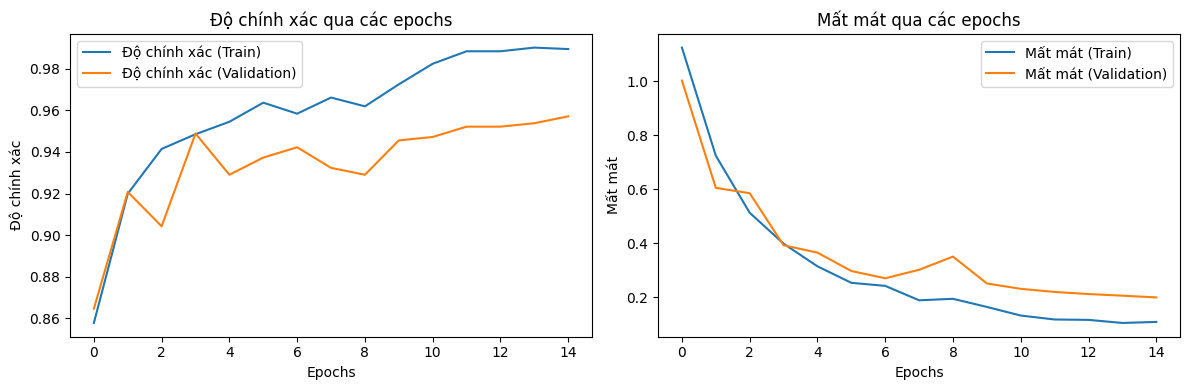

In [ ]:
# Vẽ biểu đồ độ chính xác
plt.figure(figsize=(12, 4))

# Đồ thị độ chính xác
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Độ chính xác (Train)')
plt.plot(history.history['val_accuracy'], label='Độ chính xác (Validation)')
plt.title('Độ chính xác qua các epochs')
plt.xlabel('Epochs')
plt.ylabel('Độ chính xác')
plt.legend()

# Đồ thị mất mát
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Mất mát (Train)')
plt.plot(history.history['val_loss'], label='Mất mát (Validation)')
plt.title('Mất mát qua các epochs')
plt.xlabel('Epochs')
plt.ylabel('Mất mát')
plt.legend()

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/Essay/training_accuracy_lossIV3ver3.png')
plt.show()


In [ ]:
# Dự đoán trên tập test
test_generator.reset()  # Đảm bảo thứ tự chính xác của dữ liệu
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Chọn lớp có xác suất cao nhất

# Lấy nhãn thực tế từ tập test
y_true = test_generator.classes

# Tính toán các chỉ số
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# In kết quả
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# In Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

# In Classification Report (bao gồm precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


19/19 ━━━━━━━━━━━━━━━━━━━━ 169s 9s/step
Accuracy: 0.9490
Precision: 0.9496
Recall: 0.9490
F1 Score: 0.9489
Confusion Matrix:
[[115   7   0   0   0]
 [  3 108  11   1   1]
 [  0   2 115   1   1]
 [  0   1   1 116   0]
 [  0   1   1   0 123]]

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.97      0.94      0.96       122
            im_Koilocytotic       0.91      0.87      0.89       124
             im_Metaplastic       0.90      0.97      0.93       119
               im_Parabasal       0.98      0.98      0.98       118
im_Superficial-Intermediate       0.98      0.98      0.98       125

                   accuracy                           0.95       608
                  macro avg       0.95      0.95      0.95       608
               weighted avg       0.95      0.95      0.95       608



### 8. Vẽ Confusion Matrix

19/19 ━━━━━━━━━━━━━━━━━━━━ 157s 8s/step
Accuracy: 0.9490
Precision: 0.9496
Recall: 0.9490
F1 Score: 0.9489


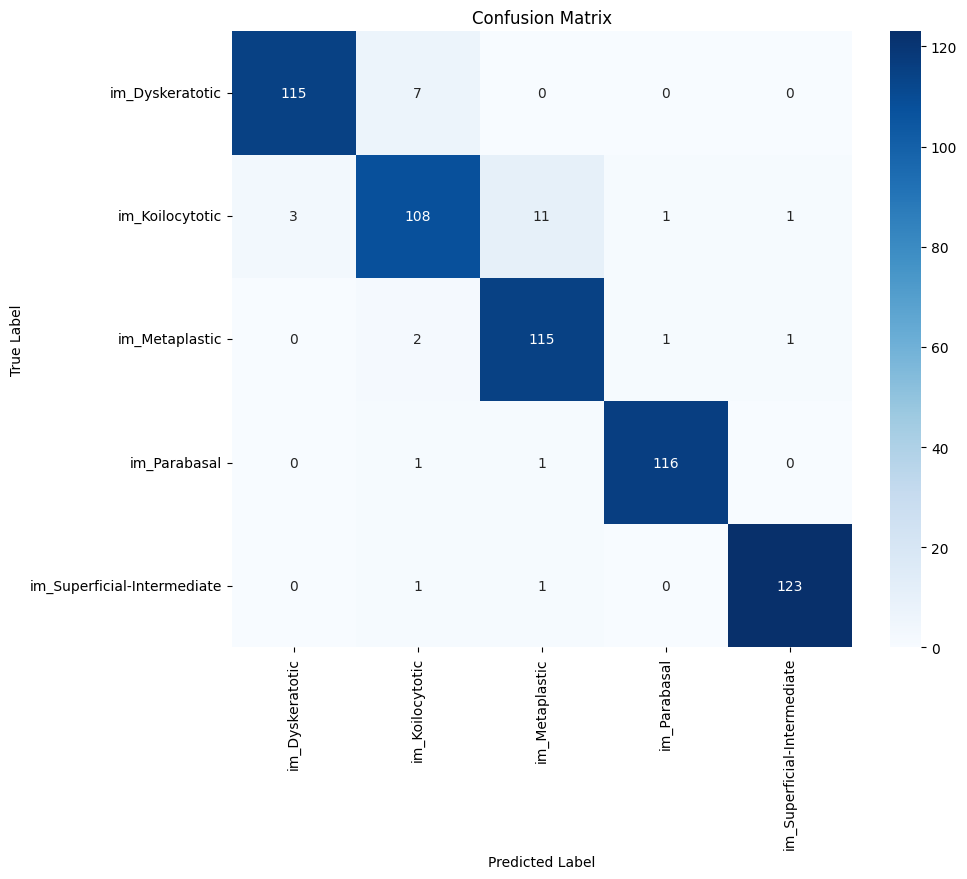


Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.97      0.94      0.96       122
            im_Koilocytotic       0.91      0.87      0.89       124
             im_Metaplastic       0.90      0.97      0.93       119
               im_Parabasal       0.98      0.98      0.98       118
im_Superficial-Intermediate       0.98      0.98      0.98       125

                   accuracy                           0.95       608
                  macro avg       0.95      0.95      0.95       608
               weighted avg       0.95      0.95      0.95       608



In [ ]:
# Dự đoán trên tập test
test_generator.reset()  # Đảm bảo thứ tự chính xác của dữ liệu
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Chọn lớp có xác suất cao nhất

# Lấy nhãn thực tế từ tập test
y_true = test_generator.classes

# Tính toán các chỉ số
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# In kết quả
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Tính toán và vẽ Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Lưu ảnh Confusion Matrix
plt.savefig("confusion_matrix_IV3ver3.png", dpi=300, bbox_inches='tight')
plt.show()

# In Classification Report (bao gồm precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


### 9. Vẽ đường cong ROC

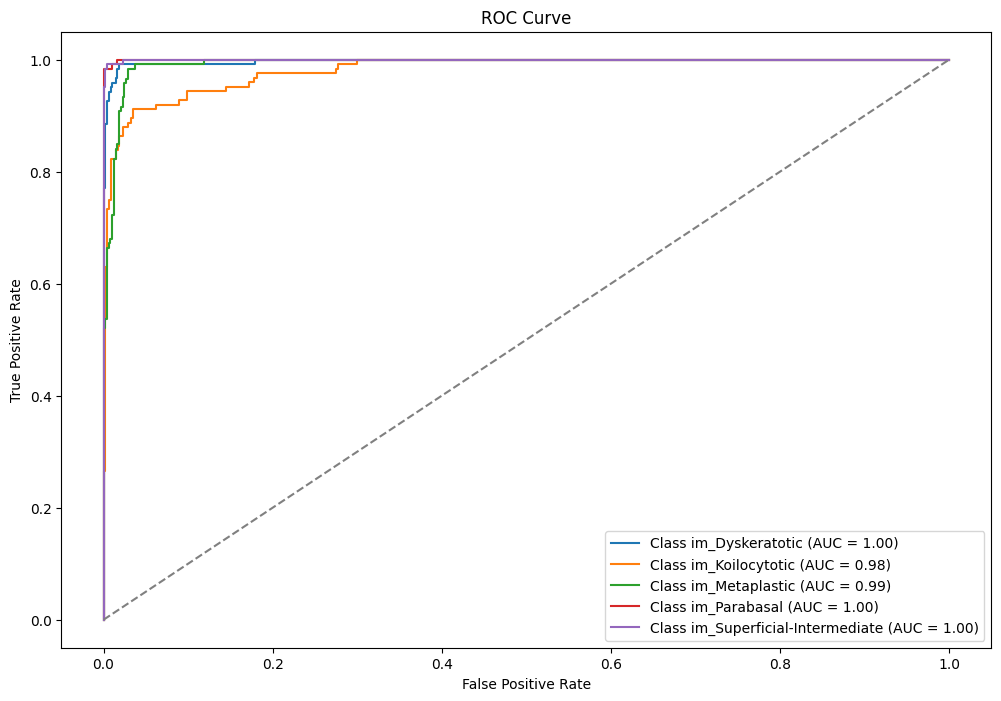

In [ ]:
# Chuyển đổi y_true sang định dạng nhị phân
n_classes = len(test_generator.class_indices)
y_true_binary = label_binarize(y_true, classes=range(n_classes))

# Vẽ ROC cho từng lớp
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {list(test_generator.class_indices.keys())[i]} (AUC = {roc_auc:.2f})")

# Vẽ đường chéo
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Định dạng biểu đồ
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

# Lưu ảnh vào Drive
plt.savefig("roc_auc_curve_Incepver3.png", dpi=300, bbox_inches='tight')
plt.show()
